<a href="https://colab.research.google.com/github/kidrono/PyTorch-Food-Classification/blob/main/pytorch_food_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
import requests
import zipfile
from pathlib import Path
data_path = Path("data/")
img_path = data_path / "pizza_steak_sushi"

if img_path.is_dir():
  print("already exists")
else:
  img_path.mkdir(parents=True, exist_ok=True)




In [4]:
with open(data_path/"pizza_steak_sushi.zip", 'wb') as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("downloading data")
  f.write(request.content)

with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", 'r') as zip_ref:
  zip_ref.extractall(img_path)

downloading data


In [5]:
import os
def walk_through_dir(dir_path):
  for dirpath, dirname, filename in os.walk(dir_path):
    print(f"There are {len(dirname)} directories and {len(filename)} images in {dirpath}")

In [6]:
walk_through_dir(img_path)

There are 2 directories and 0 images in data/pizza_steak_sushi
There are 3 directories and 0 images in data/pizza_steak_sushi/test
There are 0 directories and 19 images in data/pizza_steak_sushi/test/steak
There are 0 directories and 31 images in data/pizza_steak_sushi/test/sushi
There are 0 directories and 25 images in data/pizza_steak_sushi/test/pizza
There are 3 directories and 0 images in data/pizza_steak_sushi/train
There are 0 directories and 75 images in data/pizza_steak_sushi/train/steak
There are 0 directories and 72 images in data/pizza_steak_sushi/train/sushi
There are 0 directories and 78 images in data/pizza_steak_sushi/train/pizza


In [7]:
train_dir = img_path / "train"
test_dir = img_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

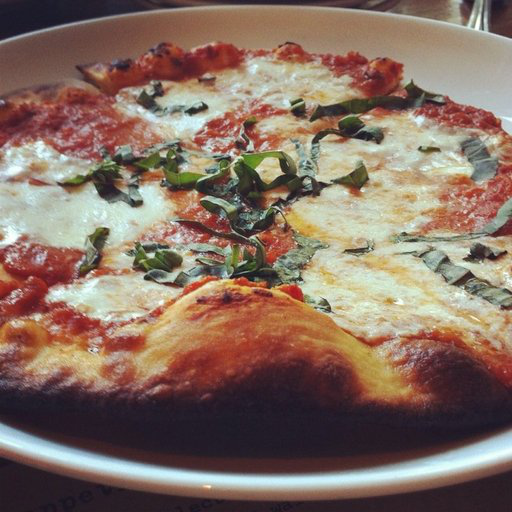

In [8]:
import random
from PIL import Image

random.seed(42)

image_path_list = list(img_path.glob("*/*/*.jpg"))

rand_img_path = random.choice(image_path_list)

img_class = rand_img_path.parent.stem

img = Image.open(rand_img_path)

img

In [9]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [10]:
data_transform = transforms.Compose([transforms.Resize(size=(64,64)), 
                                     transforms.RandomHorizontalFlip(p=0.5),
                                     transforms.ToTensor()])

In [11]:
from torchvision import datasets

train_data = datasets.ImageFolder(root=train_dir, 
                                  transform=data_transform,
                                  target_transform=None)

test_data = datasets.ImageFolder(root=test_dir, transform=data_transform)

In [12]:
class_names = train_data.classes
class_dict = train_data.class_to_idx

In [13]:
from torch.utils.data import DataLoader
BATCH_SIZE = 32
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=1,
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                              batch_size=BATCH_SIZE,
                              num_workers=1,
                              shuffle=False)
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7f0270ed7fa0>,
 <torch.utils.data.dataloader.DataLoader at 0x7f0270ed7f70>)

In [14]:
img, label = next(iter(train_dataloader))
img.shape

torch.Size([32, 3, 64, 64])

## Costum Dataset

In [15]:
import os
import pathlib
from torch.utils.data import Dataset
from typing import Tuple, Dict, List

In [16]:
target_directory = train_dir

class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

['pizza', 'steak', 'sushi']

In [17]:
def find_classes(directory):
  class_names_found = sorted([entry.name for entry in list(os.scandir(directory))])
  class_to_idx = {class_name: i for i, class_name in enumerate(class_names_found)}
  return class_names_found, class_to_idx

In [18]:
class ImageFolderCostume(Dataset):
  def __init__(self, target_dir, transform=None) -> None:
    super().__init__()
    self.paths = list(pathlib.Path(target_dir).glob("*/*.jpg"))
    self.transform = transform
    self.classes, self.class_to_idf = find_classes(target_dir)

  def load_image(self, index):
    image_path = self.paths[index]
    return Image.open(image_path)
  
  def __len__(self):
    return len(self.paths)

  def __getitem__(self, index) -> Tuple[torch.Tensor, int]:
    img = self.load_image(index)
    class_name = self.paths[index].parent.name
    class_idx = self.class_to_idx[class_name]
    if self.transform:
      return self.transform(img), class_idx
    else:
      return img, class_idx

In [19]:
train_transform = transforms.Compose([transforms.Resize(size=(64,64)), 
                                     transforms.RandomHorizontalFlip(p=0.5),
                                     transforms.ToTensor()])

test_transform = transforms.Compose([transforms.Resize(size=(64,64)), 
                                     transforms.ToTensor()])

In [26]:
train_data_custom = ImageFolderCostume(target_dir=train_dir, transform=train_transform)

test_data_custom = ImageFolderCostume(target_dir=test_dir, transform=test_transform)

In [21]:
import matplotlib.pyplot as plt

In [22]:
def display_random_images(dataset, classes, n=10, dislay_shape=True, seed=None):
  if n > 10:
    n = 10
    display_shape = False
  if seed:
    random.seed(seed)
  random_samples_idx = random.sample(range(len(dataset)), k=n)
  for i, targ_sample in enumerate(random_samples_idx):
    img, lbl = dataset[targ_sample][0], dataset[targ_sample][1]
    img_permute = img.permute(1,2,0)
    plt.subplot(1, n, i+1)
    plt.imshow(img_permute)
    plt.axis(False)
    plt.title(classes[lbl])

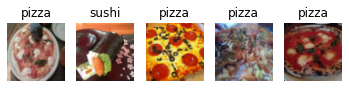

In [23]:
display_random_images(train_data, class_names, n=5)

In [27]:
NUM_WORKERS = os.cpu_count()

train_dataloader_costume = DataLoader(dataset=train_data_custom,
                                      batch_size=BATCH_SIZE,
                                      num_workers=0,
                                      shuffle=True)

test_dataloader_costume = DataLoader(dataset=test_data_custom,
                                      batch_size=BATCH_SIZE,
                                      num_workers=0,
                                      shuffle=False)

In [28]:
test_dataloader_costume